In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

from scipy.misc import imread, imsave
import cPickle as pickle
import yaml
import collections
from tqdm import tqdm
import time
from scipy.ndimage.interpolation import zoom

In [110]:
height = 32
hww = 3

def np_way(spec, meds):
    bs = spec.shape[0]  # avoid using self.batch_size as last batch may be smaller
    X = np.zeros((bs, 4, height, 2*hww), np.float32)
    

    for count in range(10):
        
        #X[count, 0] = 

        X[count, 1] = spec[count, 0] - meds[count]
        # X[count, 0] = (X[count, 0] - X[count, 0].mean()) / X[count, 0].std()
        X[count, 0] = (X[count, 1] - X[count, 1].mean(1, keepdims=True)) / (X[count, 1].std(1, keepdims=True) + 0.000001)

        X[count, 2] = (X[count, 1] - X[count, 1].mean()) / (X[count, 1].std()  + 0.0000001)
        X[count, 3] = X[count, 1] / X[count, 1].max()

    return X

In [111]:
import lasagne, lasagne.layers
from lasagne.layers import InputLayer, ReshapeLayer
import theano
import theano.tensor as T

class NormalisationLayer(lasagne.layers.MergeLayer):
    def __init__(self, incomings, **kwargs):
        super(NormalisationLayer, self).__init__(incomings, **kwargs)
        # no parameters to define

    def get_output_for(self, input, **kwargs):
        
        x, medians = input
        # Subtracting logged median from each channel
        
        # hack to make broadcastanle
        x = x - medians.repeat(6, 3)

        flattened = x.flatten(3)  # BxCxHxW --> BxCxHW

        # Rescaling each channel to be between 0 and 1
        A = flattened / (flattened.max(2, keepdims=True) + 0.000001)
        A = A.reshape(x.shape)

        B = x# - medians

        # Whitening each spectrogram
        C = flattened - flattened.mean(2, keepdims=True)
        C = C / (C.std(2, keepdims=True) + 0.0000001)
        C = C.reshape(x.shape)

        # Whitening each row of each spectrogram
        D = x - x.mean(3, keepdims=True)
        D = D / (D.std(3, keepdims=True) + 0.0000001)

        return T.concatenate((D, B, C, A), axis=1)

    def get_output_shape_for(self, input_shapes):
        input_shape = input_shapes[0]
        return (input_shape[0], input_shape[1], input_shape[2], input_shape[3])



    
def theano_way(spec, meds):
    x_in = InputLayer((10, 1, height, 2*hww))
    meds_in = InputLayer((10, 1, height, 1))

    out = NormalisationLayer((x_in, meds_in))
    
    t_out = lasagne.layers.get_output(out)

    fn = theano.function([x_in.input_var, meds_in.input_var], t_out)
    return fn(spec.astype(np.float32), meds.astype(np.float32))


print spec.shape, this_med.shape

t_result = theano_way(spec, this_med)

(10, 1, 32, 6) (10, 1, 32, 1)


In [112]:

np.random.seed(10)
spec = np.random.rand(10, 1, height, 2*hww)
this_med = spec[:, 0:1, :, 0:1]
print this_med.shape
print spec.shape

np_result = np_way(spec, this_med)
t_result = theano_way(spec, this_med)

print np_result.shape, t_result.shape

(10, 1, 32, 1)
(10, 1, 32, 6)
(10, 4, 32, 6) (10, 4, 32, 6)


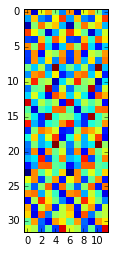

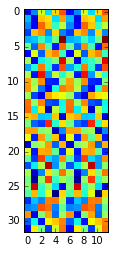

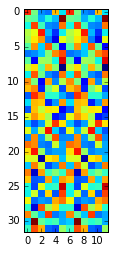

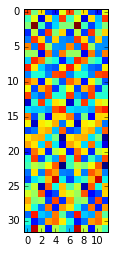

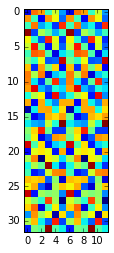

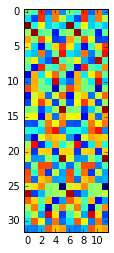

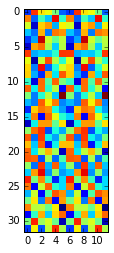

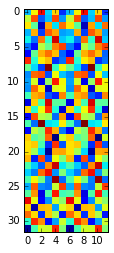

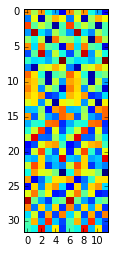

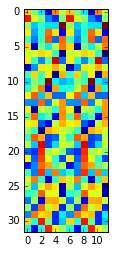

In [113]:
for idx in range(10):
    A = np_result[idx, 0]
    B = t_result[idx, 0]
    im = np.hstack((A, B))
    plt.figure()
    plt.imshow(im, interpolation='nearest')